# Airbnb Host Posts Topic Modeling with LDA

In [ ]:
# -------------------------
# 1. Import Libraries
# -------------------------

import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
# -------------------------
# 2. Load Data
# -------------------------

df = pd.read_csv("../datasets/airbnb_web_scraping.csv")

# Drop duplicates and missing values
df = df.drop_duplicates(subset=["text"])
df = df.dropna(subset=["text"])

texts = df["text"].tolist()

In [6]:
# -------------------------
# 3. Preprocess Text
# -------------------------
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and token.text not in STOP_WORDS
    ]
    return " ".join(tokens)

clean_texts = [preprocess(t) for t in texts]

In [7]:
# -------------------------
# 4. Vectorize
# -------------------------
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
X = vectorizer.fit_transform(clean_texts)

In [8]:
# -------------------------
# 5. Train LDA Model
# -------------------------
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=5, random_state=42)

In [9]:
# -------------------------
# 6. Print Topics
# -------------------------
def print_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ",
              [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out())

Topic 0:  ['guest', 'airbnb', 'protocol', 'long', 'cleaning', 'host', 'clean', 'house', 'check', 'take']
Topic 1:  ['cleaning', 'clean', 'service', 'thank', 'look', 'host', 'company', 'airbnb', 'guest', 'hello']
Topic 2:  ['clean', 'guest', 'cleaning', 'service', 'airbnb', 'find', 'host', 'look', 'home', 'place']
Topic 3:  ['cleaning', 'fee', 'guest', 'clean', 'charge', 'host', 'stay', 'airbnb', 'pay', 'day']
Topic 4:  ['clean', 'leave', 'host', 'cleaning', 'use', 'guest', 'house', 'towel', 'want', 'linen']


In [10]:
# -------------------------
# 6. Assign Topics to Posts
# -------------------------
topic_values = lda.transform(X)
df["topic"] = topic_values.argmax(axis=1)

In [12]:
# =========================
# 7. Visualizations
# =========================

feature_names = vectorizer.get_feature_names_out()

# Set stop words and topic labels
stopwords = set(STOP_WORDS)
stopwords.update(['thank', 'clean', 'airbnb', 'guest', 'host', 'hello', 'hi',
                  'place', 'home', 'house', 'stay', 'room', 'day'])

topic_labels = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E"}

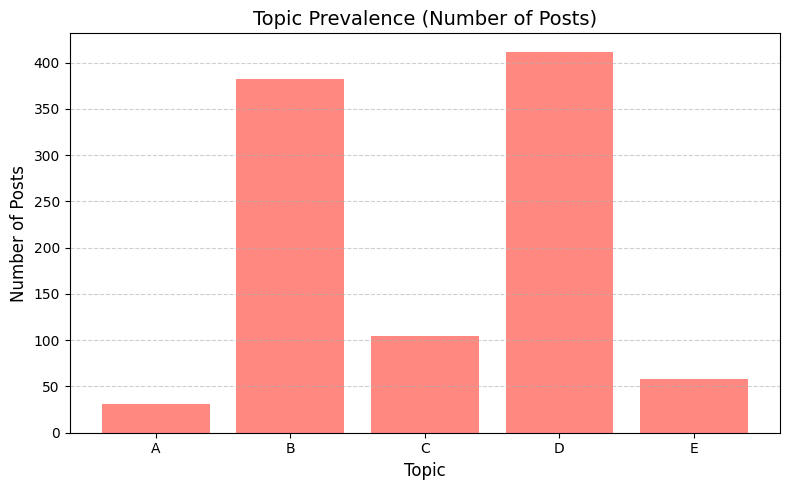

In [ ]:
# --- A) Topic prevalence (number of posts per topic) ---
topic_counts = df["topic"].value_counts().sort_index()
topic_names = [topic_labels.get(i, i) for i in topic_counts.index]

plt.figure(figsize=(8, 5))
plt.bar(topic_names, topic_counts.values, color="#ff8980")

plt.title("Topic Prevalence (Number of Posts)", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
save_path = "../assets/topic_prevalence.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

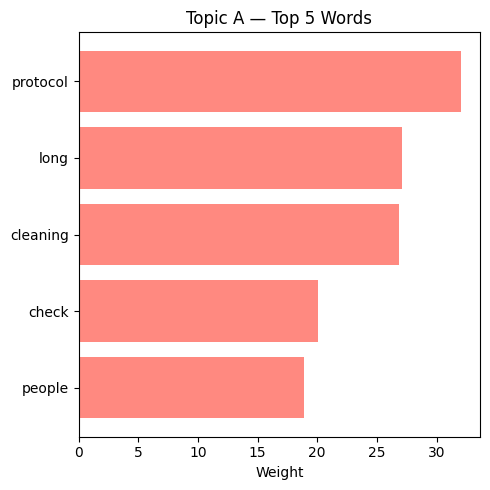

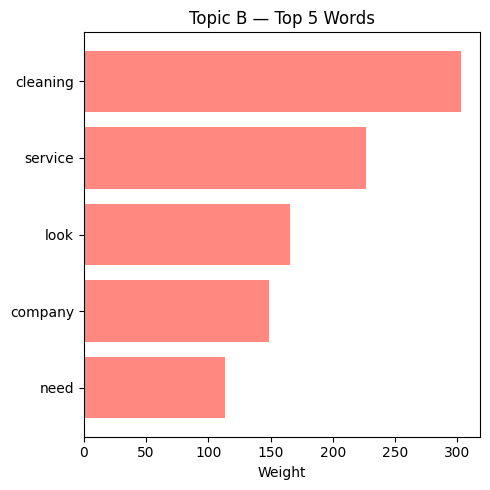

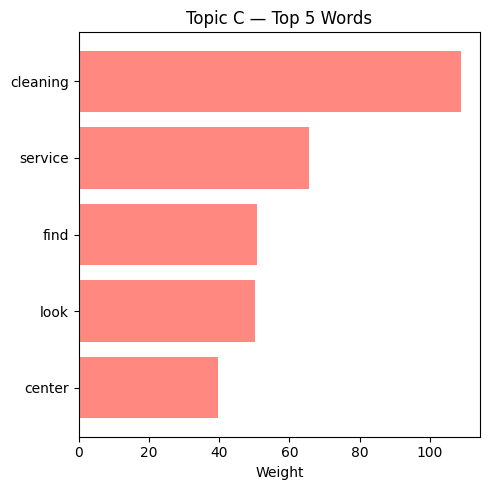

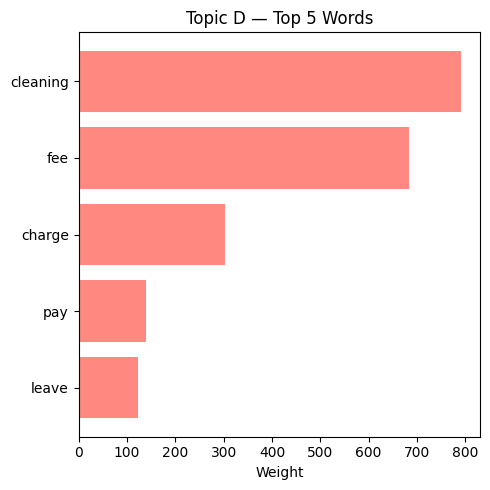

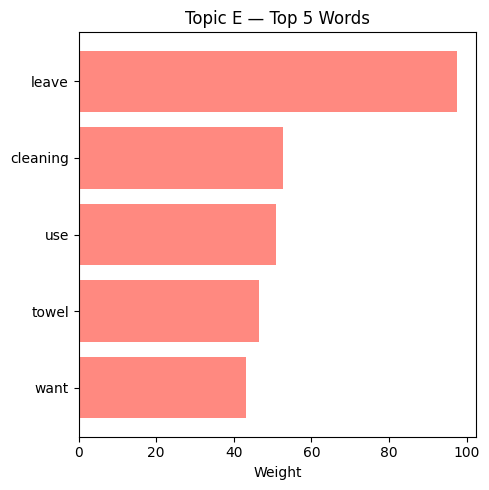

In [ ]:
# --- B) Top words per topic (bar charts) ---

def plot_top_words(model, feature_names, n_top_words=5, stopwords=None, topic_labels=None):

    for topic_idx, topic in enumerate(model.components_):
        # Get all indices sorted by weight
        sorted_idx = topic.argsort()[::-1]

        # Filter out stopwords
        words = []
        weights = []
        for i in sorted_idx:
            word = feature_names[i]
            if stopwords and word in stopwords:
                continue
            words.append(word)
            weights.append(topic[i])
            if len(words) == n_top_words:
                break

        # Use custom label
        label = topic_labels.get(topic_idx, topic_idx) if topic_labels else topic_idx

        # Create plot
        plt.figure(figsize=(5, 5))
        plt.barh(range(len(words)), weights, color='#ff8980')
        plt.gca().invert_yaxis()
        plt.yticks(range(len(words)), words)
        plt.title(f"Topic {label} — Top {n_top_words} Words")
        plt.xlabel("Weight")
        plt.tight_layout()

        # Save the plot
        save_path = f"../assets/topic_{label}_top_words.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# Call the function
plot_top_words(lda, feature_names, n_top_words=5, stopwords=stopwords, topic_labels=topic_labels)

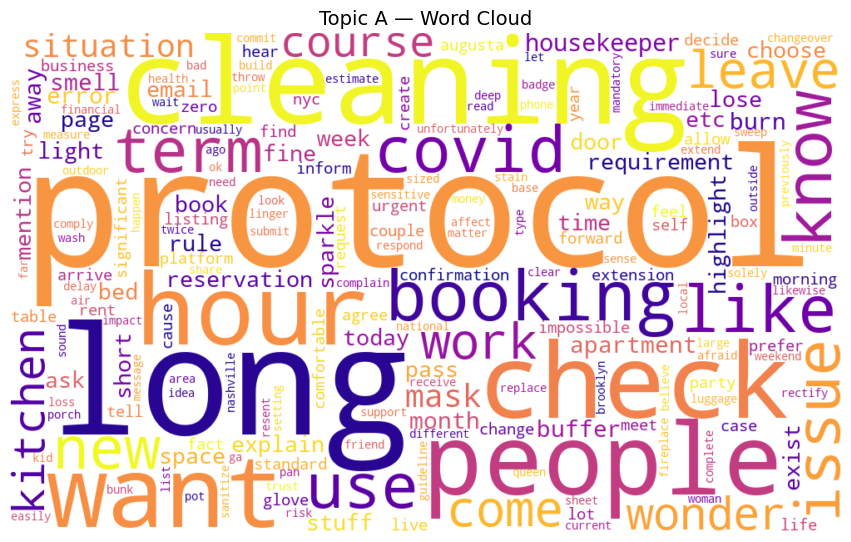

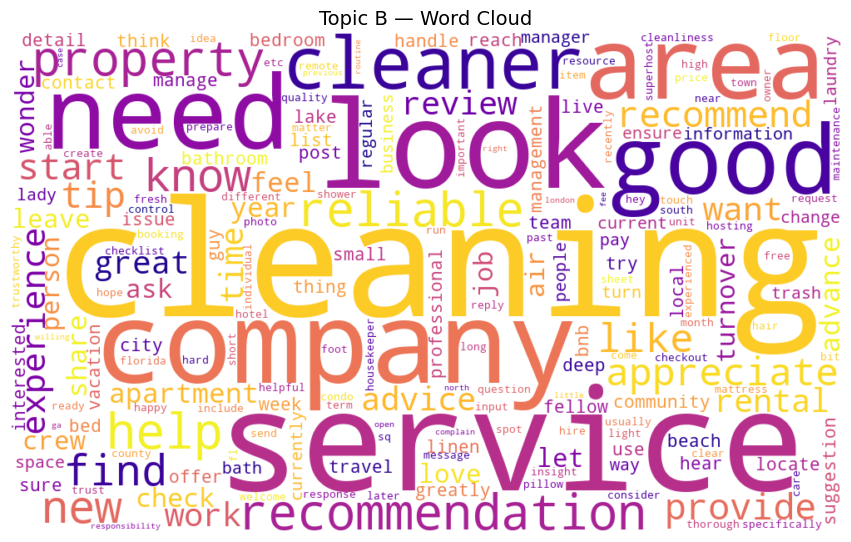

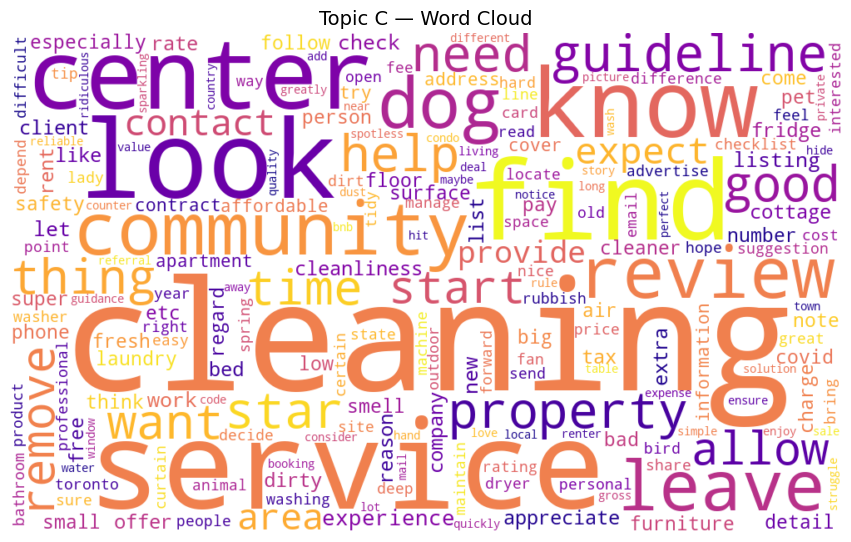

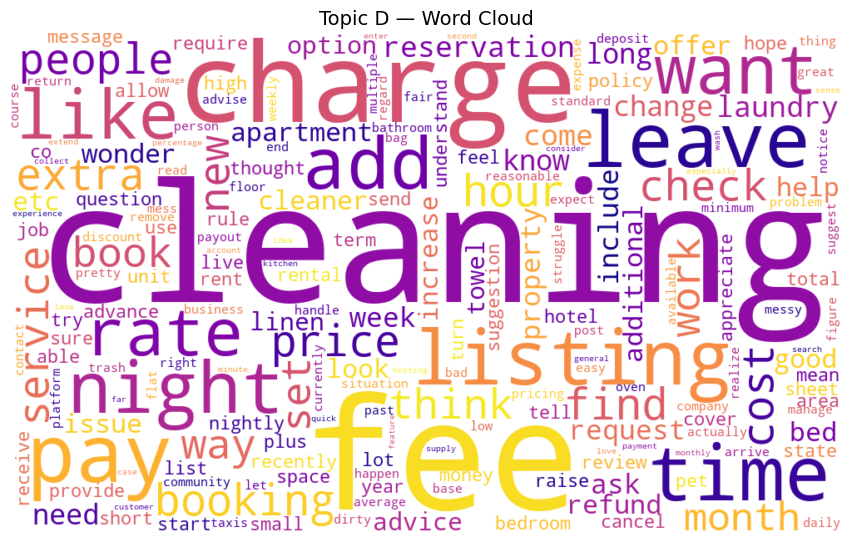

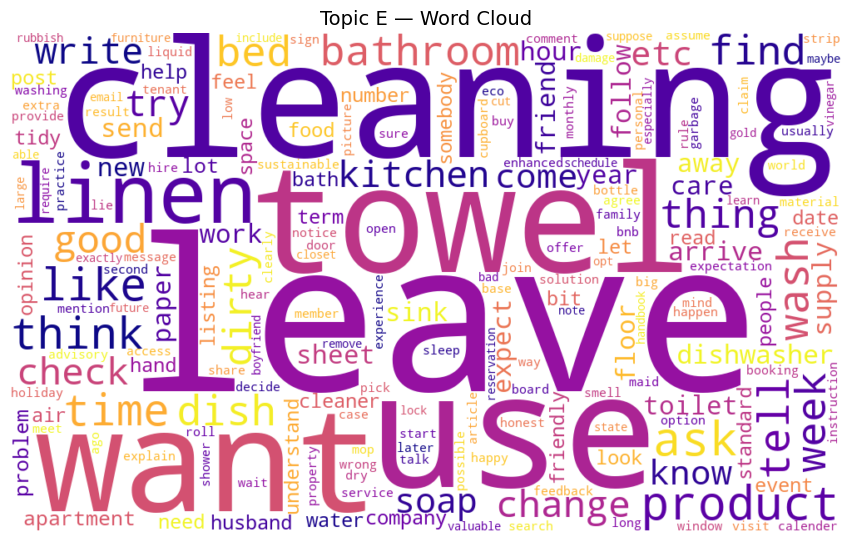

In [22]:
# --- C) Wordclouds per topic ---

for k in range(lda.n_components):
    # Get word frequencies for each topic
    freqs = {feature_names[i]: float(lda.components_[k, i])
             for i in range(len(feature_names))}
    
    # Remove stopwords
    filtered_freqs = {word: freq for word, freq in freqs.items() if word not in stopwords}

    # Create the word cloud
    wc = WordCloud(
        width=1000,
        height=600,
        background_color="white",
        colormap="plasma",
        stopwords=stopwords
    ).generate_from_frequencies(filtered_freqs)

    # Get the custom label (A–E)
    label = topic_labels.get(k, k)

    # Plot and save
    plt.figure(figsize=(9, 5.5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {label} — Word Cloud", fontsize=14)
    plt.tight_layout()

    # Save each word cloud
    save_path = f"../assets/topic_{label}_wordcloud.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()